<a href="https://colab.research.google.com/github/Hadrien-Cornier/cool-nn-stuff/blob/main/jax_xla_hlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XLA : Accelerated linear algebra compiler

JIT : Just-in-time compilation of JAX. Creates a graph -> XLA

In [ ]:
import jax
import jax.numpy as jnp

# Define a simple MLP layer
def mlp_layer(x, w, b):
    return jax.nn.relu(jnp.dot(x, w) + b)

# Initialize inputs and parameters
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (1000, 784))  # Batch of 1000 samples, each with 784 features
w = jax.random.normal(key, (784, 256))   # Weights for the layer
b = jnp.zeros(256)                       # Biases for the layer

In [ ]:
# Timing the execution without JIT
%timeit mlp_layer(x, w, b).block_until_ready()

39 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Apply JIT compilation
mlp_layer_jit = jax.jit(mlp_layer)

# Pre-compile the function
mlp_layer_jit(x, w, b).block_until_ready()

# Timing the execution with JIT
%timeit mlp_layer_jit(x, w, b).block_until_ready()

19.6 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But How does XLA achieve this speedup ?

**Kernel Fusion:** XLA can fuse multiple operations into a single kernel, reducing the overhead of launching multiple kernels and improving memory access patterns.

**Loop Unrolling:** XLA can unroll loops to reduce the number of iterations and improve parallelism.

**Memory Layout Optimization:** XLA optimizes the memory layout to improve cache utilization and reduce memory access latency.

**Hardware-Specific Optimizations:** XLA generates code that is highly optimized for the specific hardware, leveraging specialized instructions and parallelism capabilities.




In [ ]:
# The jaxpr is an intermediate representation
# that JAX uses to describe the computation graph
import jax
import jax.numpy as jnp

# Define a simple MLP layer
def mlp_layer(x, w, b):
    return jax.nn.relu(jnp.dot(x, w) + b)

# Initialize inputs and parameters
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (1000, 784))  # Batch of 1000 samples, each with 784 features
w = jax.random.normal(key, (784, 256))   # Weights for the layer
b = jnp.zeros(256)                       # Biases for the layer

# Generate and print the jaxpr
jaxpr = jax.make_jaxpr(mlp_layer)(x, w, b)
print(jaxpr)

{ lambda ; a:f32[1000,784] b:f32[784,256] c:f32[256]. let
    d:f32[1000,256] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a b
    e:f32[1,256] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 256)] c
    f:f32[1000,256] = add d e
    g:f32[1000,256] = custom_jvp_call[
      call_jaxpr={ lambda ; h:f32[1000,256]. let
          i:f32[1000,256] = pjit[
            name=relu
            jaxpr={ lambda ; j:f32[1000,256]. let
                k:f32[1000,256] = max j 0.0
              in (k,) }
          ] h
        in (i,) }
      jvp_jaxpr_thunk=<function _memoize.<locals>.memoized at 0x7dfa291ce440>
      num_consts=0
      symbolic_zeros=False
    ] f
  in (g,) }


In [ ]:
# Define the JIT-compiled MLP layer
mlp_layer_jit = jax.jit(mlp_layer)

# Generate the XLA computation
xla_comp = jax.xla_computation(mlp_layer_jit)(x, w, b)

# Print the HLO as text
print(xla_comp.as_hlo_text())

# Optionally, save the HLO to a file
with open("mlp_layer_hlo.txt", "w") as f:
    f.write(xla_comp.as_hlo_text())

HloModule xla_computation_mlp_layer, entry_computation_layout={(f32[1000,784]{1,0}, f32[784,256]{1,0}, f32[256]{0})->(f32[1000,256]{1,0})}

relu.4 {
  Arg_0.5 = f32[1000,256]{1,0} parameter(0)
  constant.6 = f32[] constant(0)
  broadcast.7 = f32[1000,256]{1,0} broadcast(constant.6), dimensions={}
  ROOT maximum.8 = f32[1000,256]{1,0} maximum(Arg_0.5, broadcast.7)
}

mlp_layer.9 {
  Arg_0.10 = f32[1000,784]{1,0} parameter(0)
  Arg_1.11 = f32[784,256]{1,0} parameter(1)
  dot.13 = f32[1000,256]{1,0} dot(Arg_0.10, Arg_1.11), lhs_contracting_dims={1}, rhs_contracting_dims={0}
  Arg_2.12 = f32[256]{0} parameter(2)
  reshape.14 = f32[1,256]{1,0} reshape(Arg_2.12)
  broadcast.15 = f32[1,256]{1,0} broadcast(reshape.14), dimensions={0,1}
  reshape.16 = f32[256]{0} reshape(broadcast.15)
  broadcast.17 = f32[1000,256]{1,0} broadcast(reshape.16), dimensions={1}
  add.18 = f32[1000,256]{1,0} add(dot.13, broadcast.17)
  ROOT call.19 = f32[1000,256]{1,0} call(add.18), to_apply=relu.4
}

ENTRY main.22 

In [ ]:
# Save the HLO as a DOT graph
with open("mlp_layer_hlo.dot", "w") as f:
    f.write(xla_comp.as_hlo_dot_graph())

In [ ]:
!dot -Tpdf mlp_layer_hlo.dot -o mlp_layer_hlo.pdf

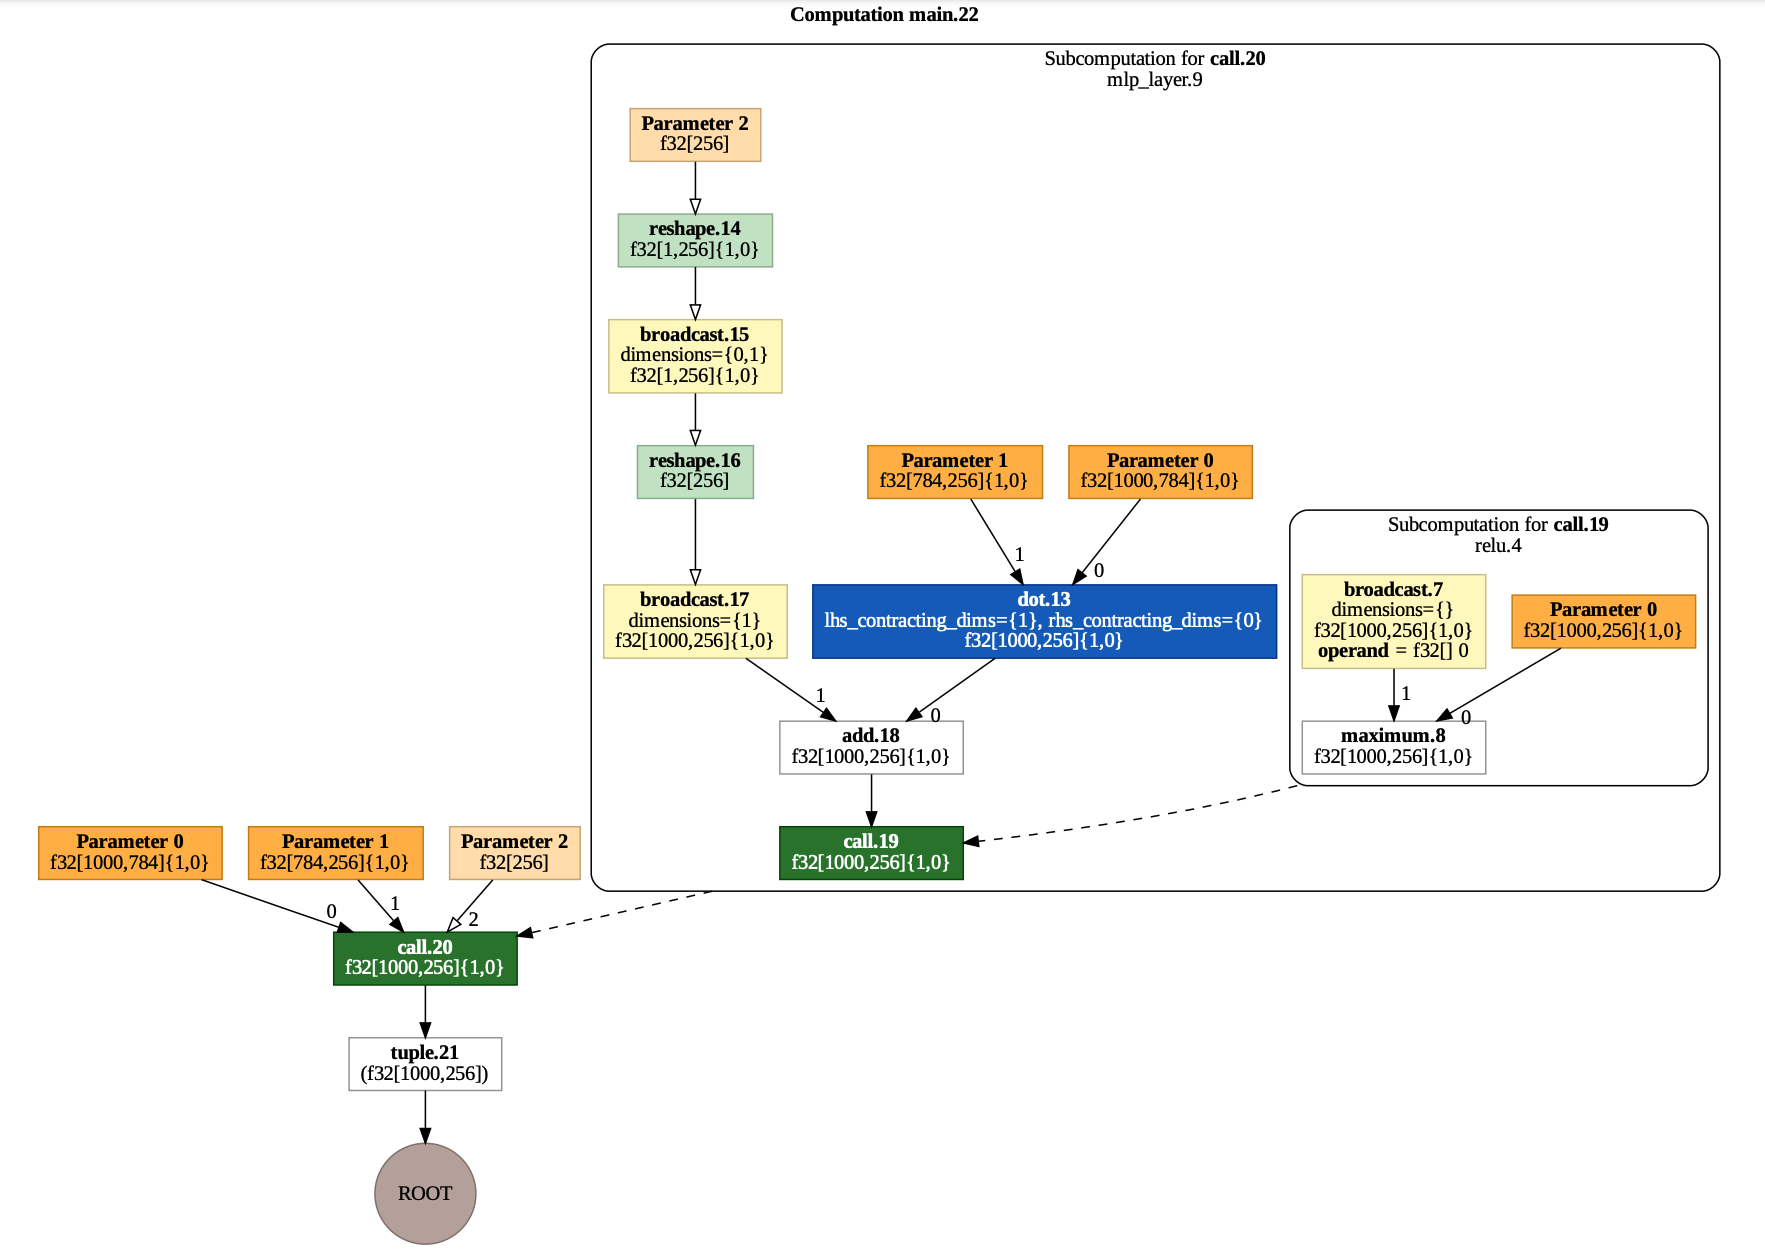

Before sending the operation to XLA to optimize it, we first represent it in this HLO


jax.xla_computation returns the XLA High-Level Optimizer (HLO) representation.



Jax : code -> HLO -> XLA

This is a debugging tool, xla might reorder, fuse operations and do other things

biases are bradcasted, the inputs are the bother the features and the weights
- Param 0 is the features  $f32[1000,784]$
- Param 1 the weight matrix $f32[784,256]{1,0}$
- Param 2 the bias $f32[256]$

(this is a simple MLP layer  $f(x)=xw+b$)

a type is type+shape, which makes sense for tensors nowadays

We have broadcast operations that copy-paste smaller tensors in the memory

Presumably XLA will balance out the need to broadcast and the order of the operations to reduce memory access maybe.

I wonder what else we gain


Let's look at the representation of dot.13 which is the matrix multiply. I wonder why lhs and rhs represent


In [ ]:
import jax.numpy as jnp
import jax.random as jr  # Import the jax.random module

def tensor_multiply(A, B):
    return jnp.einsum('ijk,kl->ijl', A, B)

key = jr.PRNGKey(0)  # Create a PRNG key
A = jr.normal(key, shape=(10, 20, 30))  # Use jr.normal for random number generation
B = jr.normal(key, shape=(30, 40))

result = tensor_multiply(A, B)

# Define the JIT-compiled MLP layer
tensor_multiply_jit = jax.jit(tensor_multiply)

# Generate the XLA computation
xla_comp = jax.xla_computation(tensor_multiply_jit)(A,B)

In [ ]:
# Save the HLO as a DOT graph
with open("tensor_multiply.dot", "w") as f:
    f.write(xla_comp.as_hlo_dot_graph())

In [ ]:
!dot -Tpdf tensor_multiply.dot -o tensor_multiply.pdf

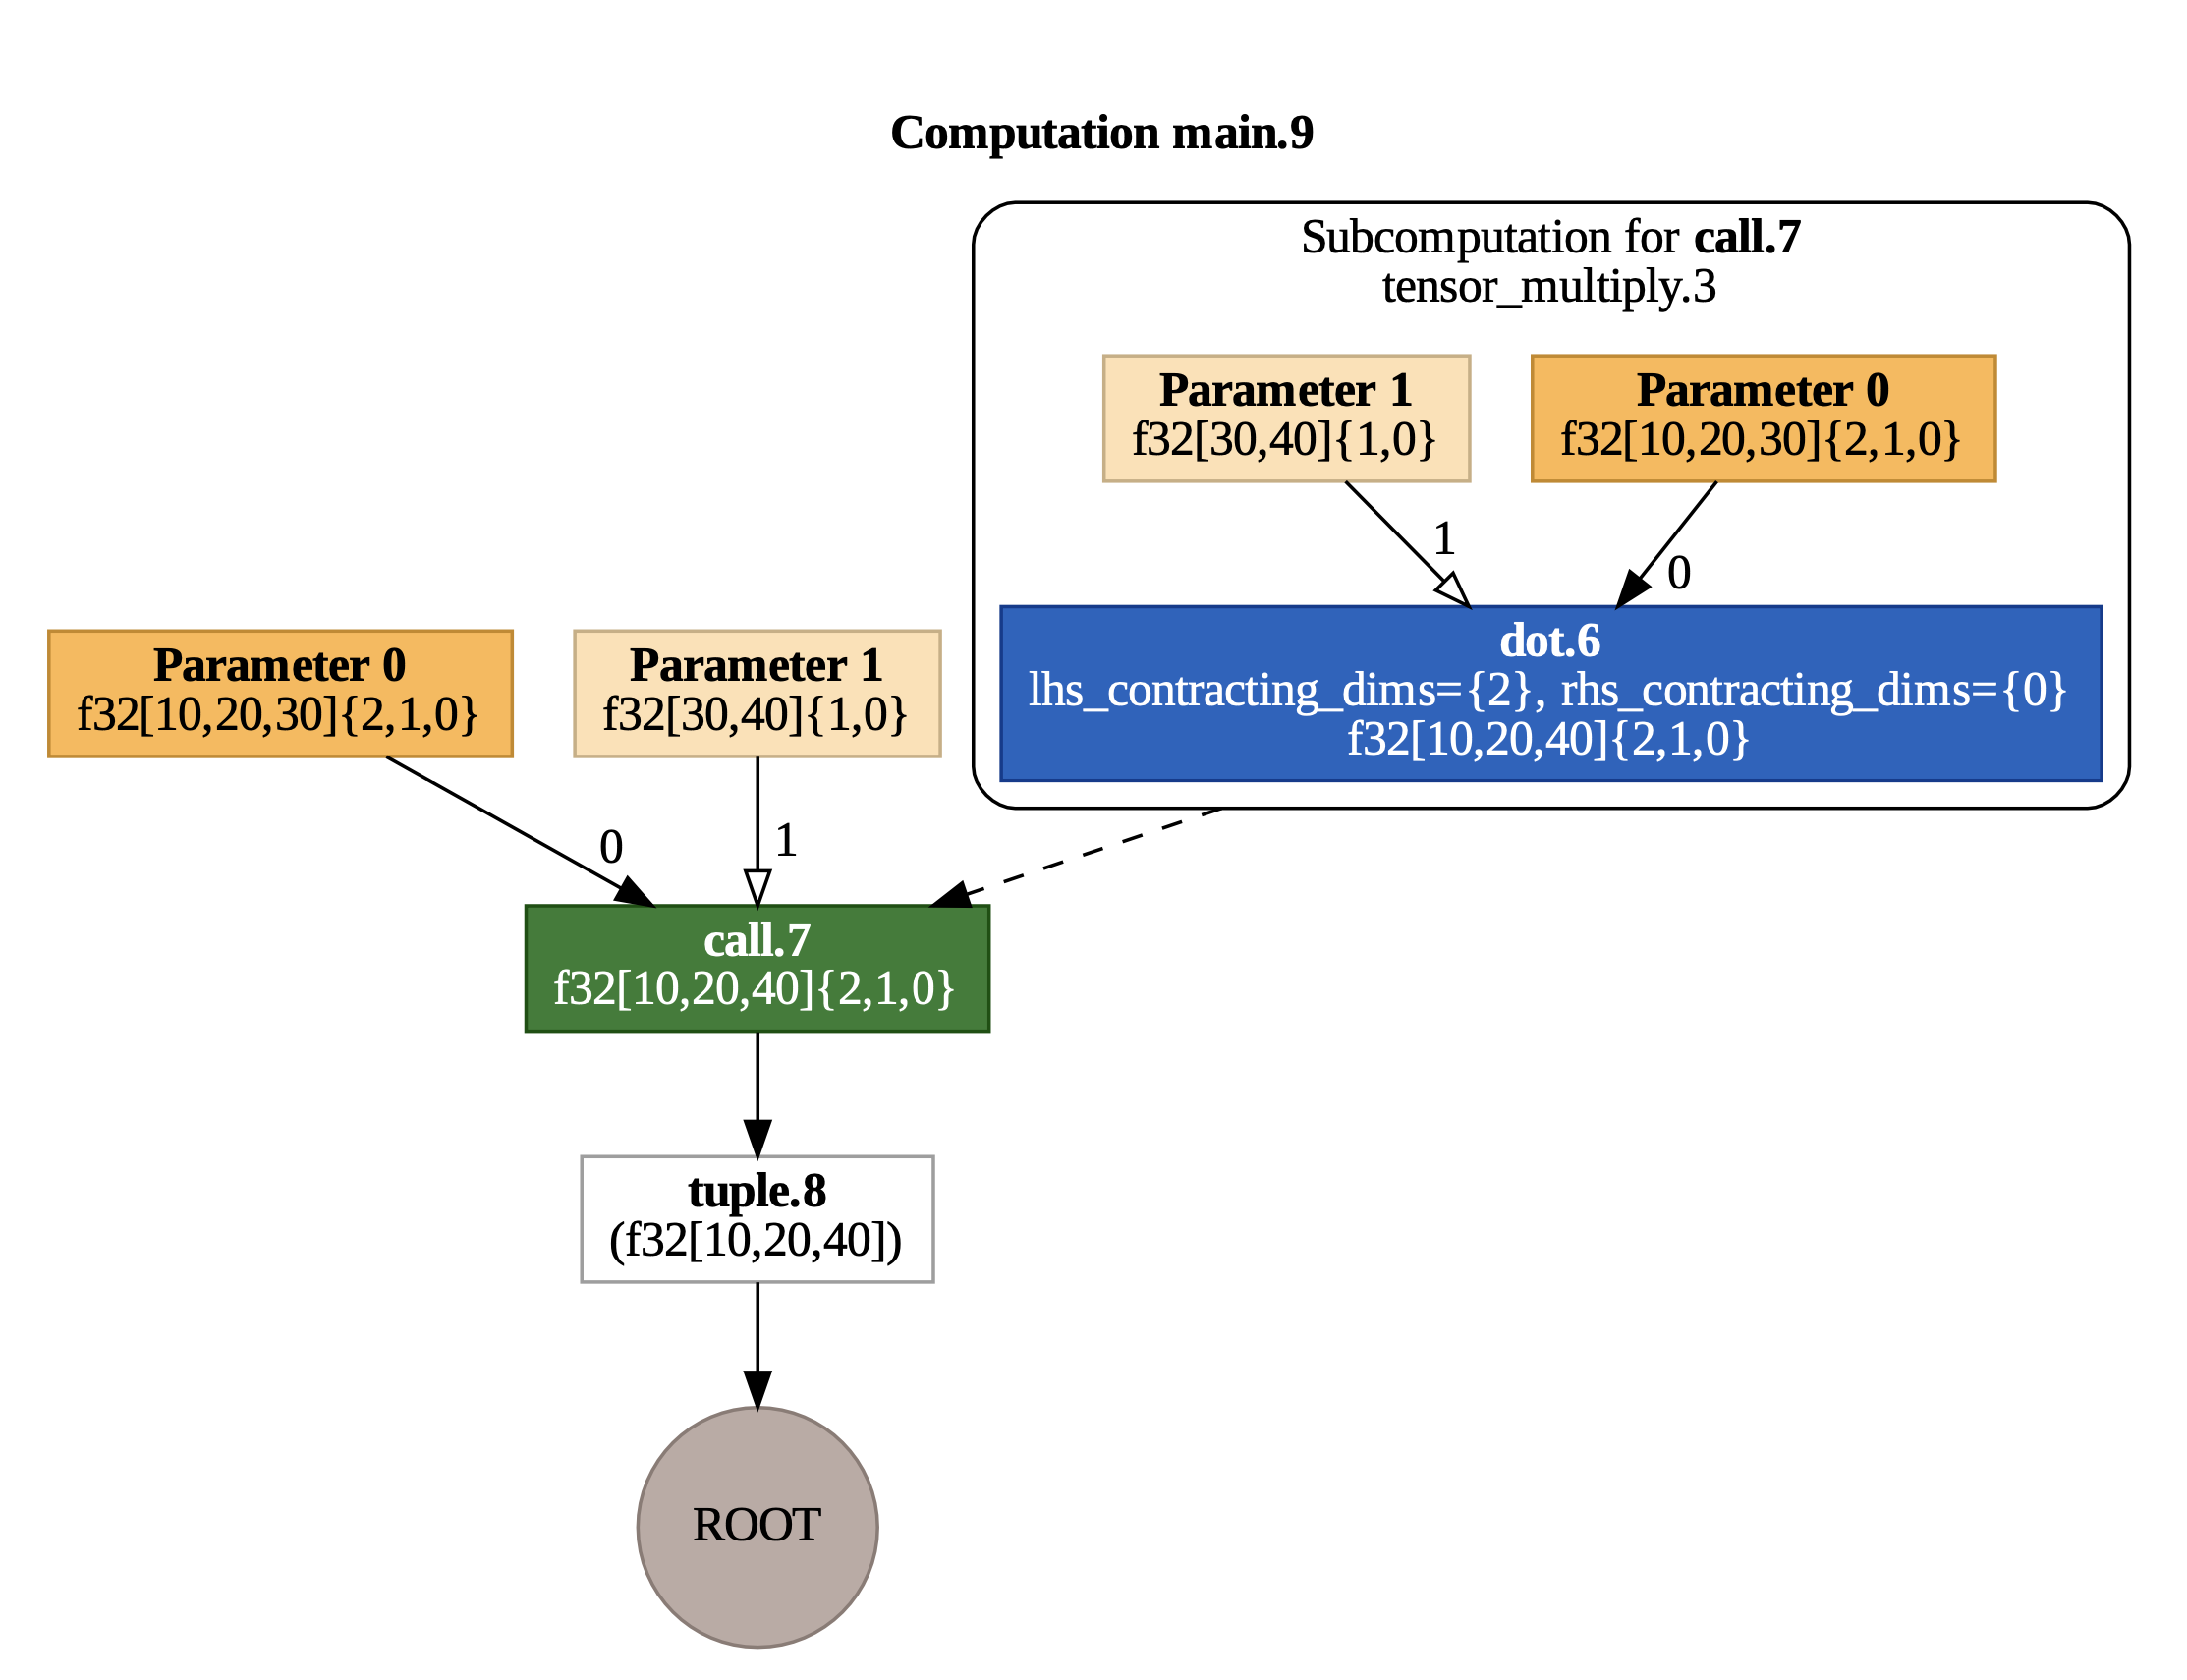

this represents this ein notation tensor operation : 'ijk,kl->ijl'

lhs_contracting_dims =2 & rhs_contracting_dims=0

because k the contracting dimension is in dimension 2 on the first tensor, dimension 0 on the second

Now let's try a more complex operation on Tensors


In [23]:
def tensor_multiply_4d(A, B):
    return jnp.einsum('ijkl,mklp->ijmp', A, B)

key = jr.PRNGKey(0)  # Create a PRNG key
A = jr.normal(key, shape=(10, 20, 30, 40))  # Use jr.normal for random number generation
B = jr.normal(key, shape=(50, 30, 40, 60))

result = tensor_multiply_4d(A, B)


# Define the JIT-compiled MLP layer
tensor_multiply_4d_jit = jax.jit(tensor_multiply_4d)

# Generate the XLA computation
xla_comp = jax.xla_computation(tensor_multiply_4d_jit)(A,B)

In [24]:
# Save the HLO as a DOT graph
with open("tensor_multiply_4d.dot", "w") as f:
    f.write(xla_comp.as_hlo_dot_graph())

In [25]:
!dot -Tpdf tensor_multiply_4d.dot -o tensor_multiply_4d.pdf

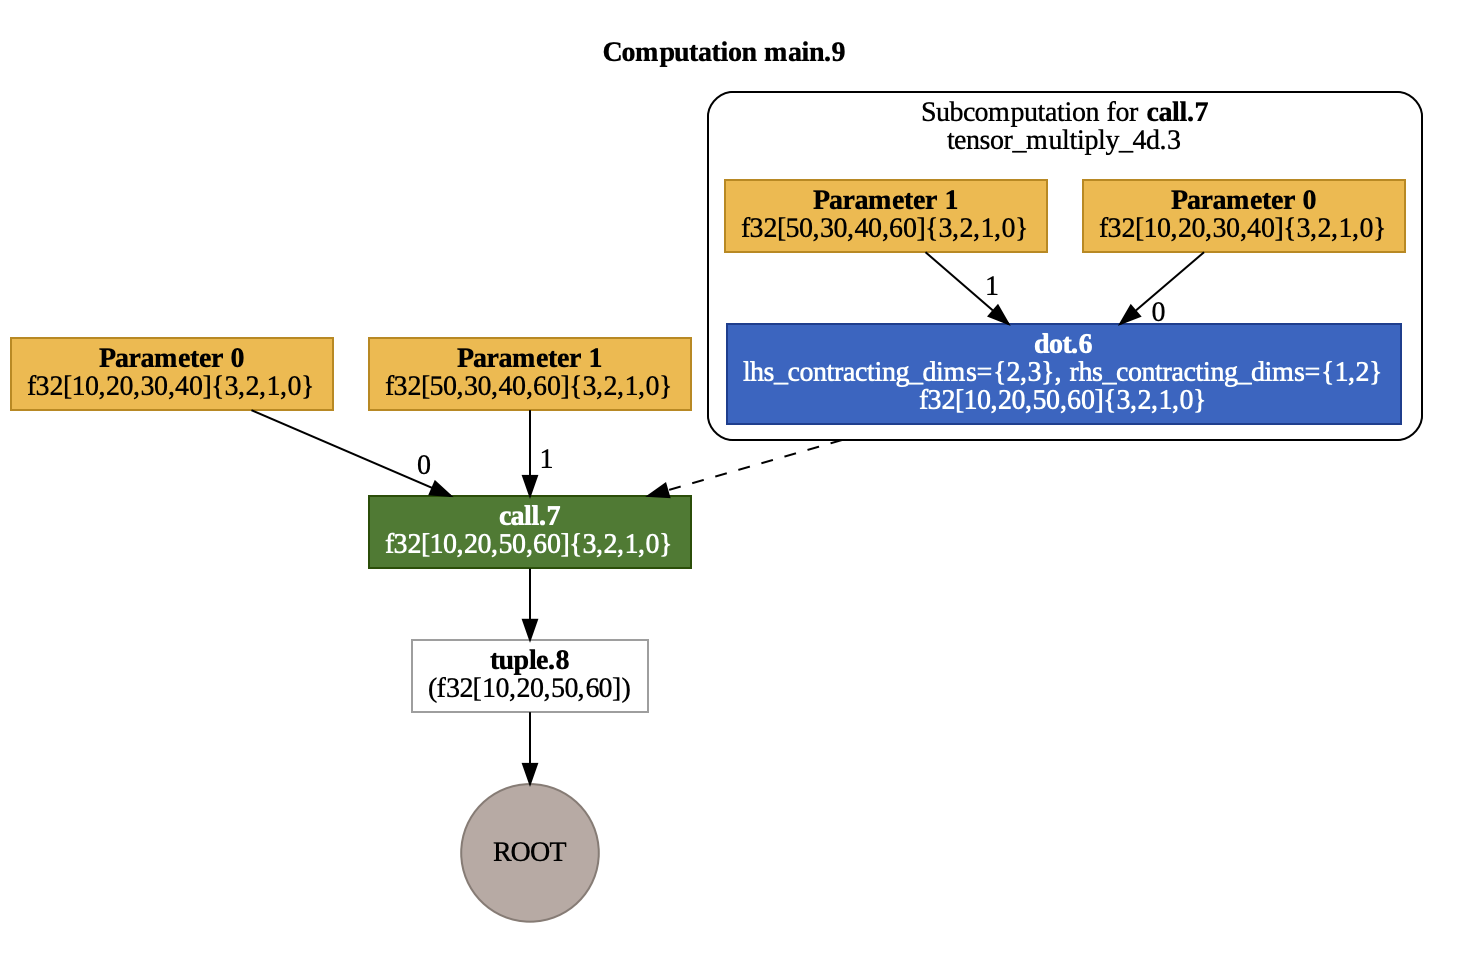

This represents ijkl,mklp->ijmp

contracting dims 23,12 = kl